In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import sys
sys.path.append('../src/cnn')

from models import ConvNet
from preprocessing import LabelEncoder


physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


def read_data(path, **kwargs):
    from scipy.interpolate import interp1d
    df = pd.read_csv(path, **kwargs)
    
    # User list comprehension to create a list of lists from Dataframe rows
    data_list_of_rows = [list(row) for row in df.values]
    
    num = int(input("input a value between 0 to 3 to choose one signal amongst the 3 signals: "))
    y_axis = data_list_of_rows[num]
    
    print("You have chosen signal:", num);
    
    column_in = len(y_axis)
    col = range(0,column_in)
    x_axis = list(col)
    
    elon_list = [11, 21, 19, 18, 29]
    data_x = np.asarray(x_axis)
    data_y = np.asarray(y_axis)

    #return data_x, data_y


    # Obtain interpolation function (input original x (time) and y (signal))
    f = interp1d(data_x, data_y)
    # Create new x (same x_min and x_max but different number of data points)
    x_new = np.linspace(data_x.min(), data_x.max(), 8192)
    # Obtain new y (based on new x)
    y_new = f(x_new)
    # return both new x and new y
    return x_new, y_new

In [7]:
NUM_TRAIN_EXAMPLES = int(1e6)
NUM_TEST_EXAMPLES = int(1e4)

NUM_CLASSES = 3
NUM_WINDOWS = 256
INPUT_SIZE = 8192

# Define label encoder to decode predictions later on
label_encoder = LabelEncoder(NUM_WINDOWS)

# Build model (should have the same parameters as the model
# in 01_cnn-train.ipynb)
model = ConvNet(
    filters=[64, 128, 128, 256, 256],
    kernel_sizes=[9, 9, 9, 9, 9],
    dropout=0.0,
    pool_type='max',
    pool_sizes=[2, 2, 2, 2, 2],
    conv_block_size=1,
    input_shape=(INPUT_SIZE, 1),
    output_shape=(NUM_WINDOWS, NUM_CLASSES),
    residual=False
)

# Load pretrained weights
# If retrained (via 01_train-cnn.ipynb), weights should be loaded as 
# outputs/weights/weight_{epoch:03d}.h5 (e.g. outputs/weights/weight_009.h5)
model.load_weights('output/weights/cnn_weights.h5')

In [50]:
# Read data (applies linear interpolation to get the right dimension)
# t = time; s = signal
#t, s = read_data('../input/training.csv',header=None, sep=',')

t, s = read_data('../input/Wand_000.csv',header=None, sep=',')



# Normalize and add batch dimension (model expect batched data)
s_norm = s[None, :, None] / s.max()


# Pass to model and make predictions
preds = model(s_norm)[0]

# .decode will filter out predictions below threshold
# and compute the appropriate locations of the peaks
probs, locs, areas = label_encoder.decode(preds, threshold=0.5)

print("Predicted locations:\n", locs * t.max())
print("\nPredicted areas:\n", areas)
print("\nPredicted probabilities:\n", probs)


peakdetects    = np.asarray(locs * t.max())

print("\ninitialpeakdetect:\n",peakdetects[0])
print("\nlastpeakdetect:\n",peakdetects[-1])
print("\nPulse Duration(msec) :\n",peakdetects[-1] - peakdetects[0])




input a value between 0 to 3 to choose one signal amongst the 3 signals: 6
You have chosen signal: 6
Predicted locations:
 [2919.43178903 2973.31809074 3034.45280615 3097.37937405 3147.09451837
 3205.61469203 3284.82390874 3344.48895188 3401.1051851  3472.15561243
 3532.12610384 3587.4686558  3664.38171142 3721.43719504 3780.22507201
 3854.54131949 3911.48138955 3975.25471006 4046.95260529 4106.50601393
 4177.96302323]

Predicted areas:
 [0.60143363 0.75353396 0.776584   0.59277415 1.3830168  2.5937288
 1.7904744  2.0992708  2.6781623  2.3614528  2.803405   3.3626602
 2.7193487  3.0454667  3.2062976  2.3597267  2.4997795  2.407187
 1.7347424  1.7538286  1.3541303 ]

Predicted probabilities:
 [0.5193845  0.6564321  0.98852587 0.9964766  0.9957998  0.9998151
 0.98729575 0.9996817  0.9999937  0.9986856  0.99995345 0.99999946
 0.99953026 0.9998702  0.99999726 0.9904963  0.9987099  0.99984366
 0.6856976  0.9564973  0.97135025]

initialpeakdetect:
 2919.4317890256643

lastpeakdetect:
 4177.9

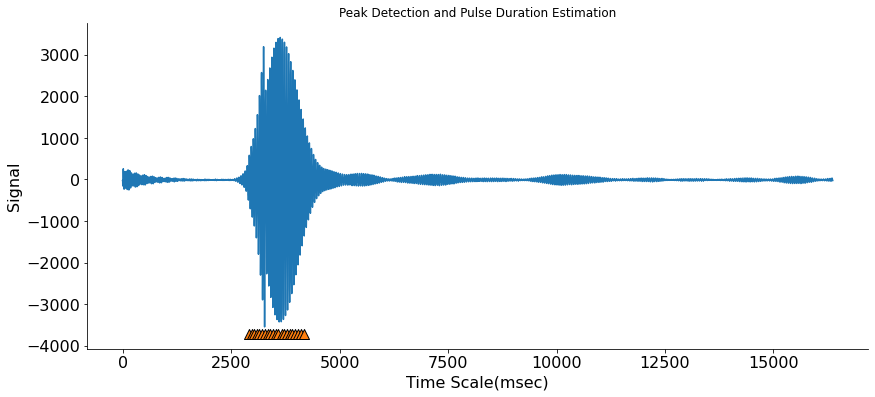

In [51]:
# Visualize locations in the chromatogram
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(t, s)

for (prob, loc, area) in zip(probs, locs, areas):
    y = s.min() - s.max() * 0.05 # location of the triangles
    ax.scatter(loc*t.max(), y, color='C1', marker='^', s=100, edgecolors='black')
    
ax.tick_params(axis='both', labelsize=16)
ax.set_title('Peak Detection and Pulse Duration Estimation')
ax.set_ylabel('Signal', fontsize=16)
ax.set_xlabel('Time Scale(msec)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

